<a href="https://colab.research.google.com/github/deepavarshini09/EEG_ALS_Detection/blob/main/EEG_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EEG - ALS DETECTION - MACHINE LEARNING PROJECT

## SECTION 0 - INTRODUCTION

In [36]:
# 🧭 SECTION 0 — OVERVIEW & SETUP
# =========================================================

# 📘 Project: EEG-based ALS Detection using EEGET-ALS Dataset
# 🎯 Objective: Build an ML + DL model to classify ALS vs Healthy EEG
# 🧩 Workflow Sections:
# 0. Setup & Overview
# 1. Load EEGET-ALS Dataset
# 2. Preprocess EEG
# 3. Feature Extraction
# 4. Model Training (Classical ML)
# 5. Deep Learning (EEGNet / CNN)
# 6. Evaluation & Explainability
# 7. Gradio GUI
# 8. Summary & References

In [37]:
# Mount Google Drive for data storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Installing the necessary packages
!pip install mne scipy numpy pandas scikit-learn xgboost matplotlib seaborn shap gradio torch torchvision torchaudio --quiet

In [39]:
# Importing standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# REQUIRED EEG and ML Libraries
import mne
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim

import shap
import gradio as gr

In [41]:
# Path configuration
BASE_DIR = "/content/drive/MyDrive/EEG_Project"

# Subdirectories for outputs (these will be created automatically)
DATASET_DIR = os.path.join(BASE_DIR, "EEGET-ALS Dataset")
PREPROC_DIR = os.path.join(BASE_DIR, "preprocessed")
FEATURE_DIR = os.path.join(BASE_DIR, "features")
MODEL_DIR = os.path.join(BASE_DIR, "models")
RESULT_DIR = os.path.join(BASE_DIR, "results")

# Create directories if they don't exist
for path in [PREPROC_DIR, FEATURE_DIR, MODEL_DIR, RESULT_DIR]:
    os.makedirs(path, exist_ok=True)

print("✅ Setup complete! Using existing dataset folder:")
print("📂 Dataset path:", DATASET_DIR)

✅ Setup complete! Using existing dataset folder:
📂 Dataset path: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset


## SECTION 1 - LOAD AND EXPLORE THE EEG-ALS DATASET

In [42]:
import os
import mne
from glob import glob

print("📂 Dataset base directory:", DATASET_DIR)

📂 Dataset base directory: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset


In [43]:
import os

edf_files = []
for root, _, files in os.walk(DATASET_DIR):
    for f in files:
        if f.endswith(".edf"):
            edf_files.append(os.path.join(root, f))

print("Found", len(edf_files), "files.")
np.save(os.path.join(BASE_DIR, "edf_file_list.npy"), np.array(edf_files))

Found 1991 files.


In [44]:
import numpy as np

edf_files = np.load(os.path.join(BASE_DIR, "edf_file_list.npy"), allow_pickle=True)
print(f"✅ Loaded {len(edf_files)} EEG file paths from saved list.")
print("Example file path:", edf_files[0])


✅ Loaded 1991 EEG file paths from saved list.
Example file path: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf


In [45]:
# =========================================================
# 🧩 SECTION 1.2 — LOAD AND VISUALIZE A SAMPLE EEG RECORDING
# =========================================================

import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the cached EDF file list (instant)
edf_files = np.load(os.path.join(BASE_DIR, "edf_file_list.npy"), allow_pickle=True)
print(f"✅ Loaded {len(edf_files)} EEG file paths.")

✅ Loaded 1991 EEG file paths.


In [46]:
# 1️⃣  Pick one EEG file to inspect (you can change index)
# ---------------------------------------------------------
sample_index = 0   # try changing this to view another file
sample_file = edf_files[sample_index]
print(f"\n📂 Loading EEG file #{sample_index+1}:\n{sample_file}")


📂 Loading EEG file #1:
/content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf


In [47]:
# 2️⃣  Load EEG data using MNE
# ---------------------------------------------------------
raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)

print("\n🧠 EEG File Info:")
print(f" - Sampling frequency: {raw.info['sfreq']} Hz")
print(f" - Number of channels: {len(raw.ch_names)}")
print(f" - Duration: {raw.n_times / raw.info['sfreq']:.2f} seconds")
print(f" - Channel names: {raw.ch_names[:10]}{'...' if len(raw.ch_names) > 10 else ''}")


🧠 EEG File Info:
 - Sampling frequency: 128.0 Hz
 - Number of channels: 32
 - Duration: 138.00 seconds
 - Channel names: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7']...


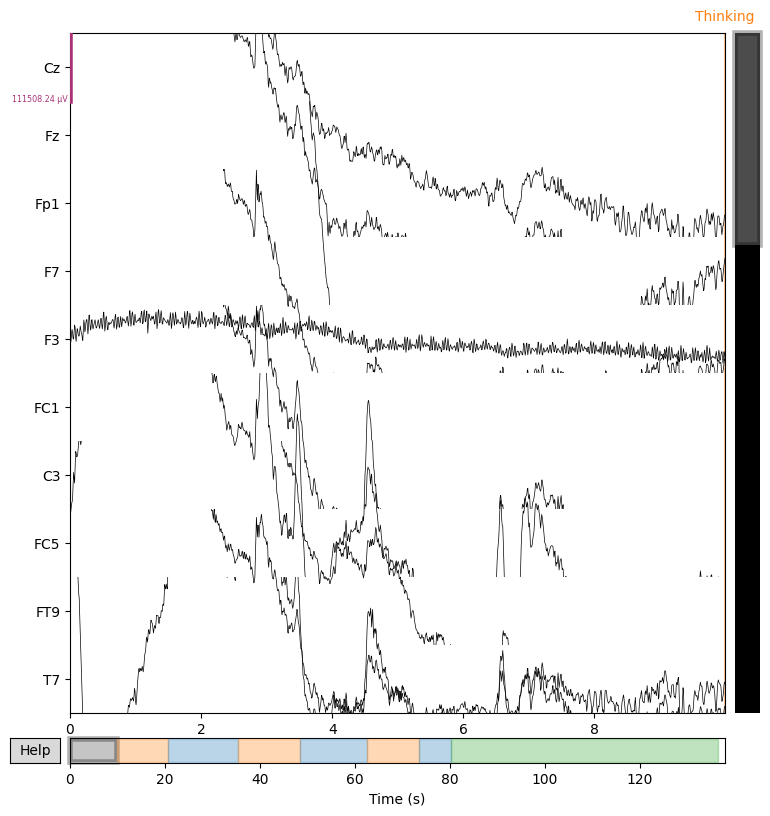

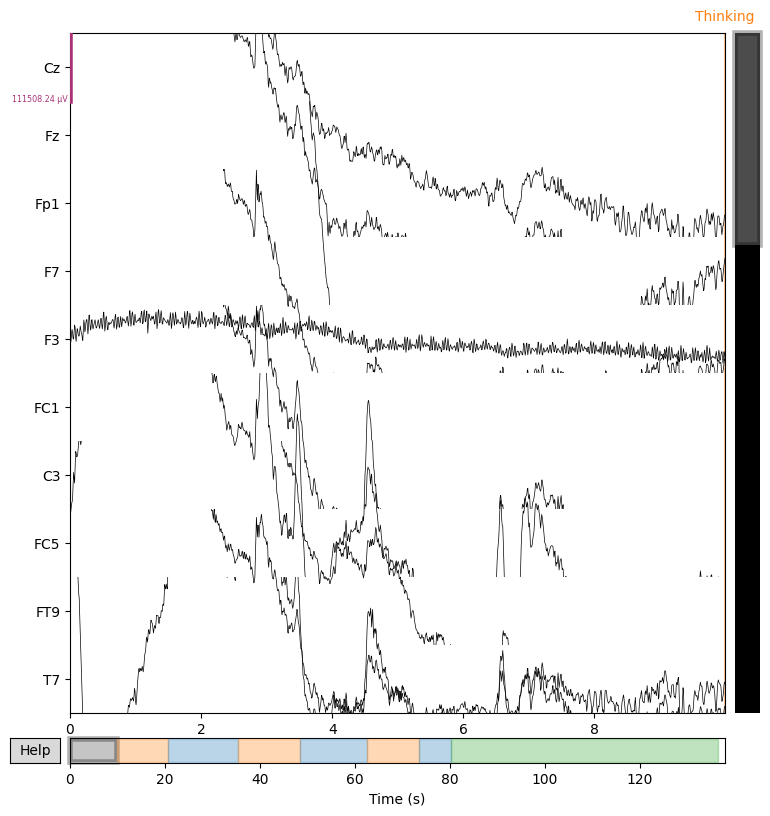

In [48]:
# 3️⃣  Visualize EEG
# ---------------------------------------------------------
# Plot first 10 seconds of 10 channels
start, duration = 0, 10  # seconds
raw.plot(start=start, duration=duration, n_channels=10, scalings='auto',
          title=f"EEG Segment Preview — {os.path.basename(sample_file)}")

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


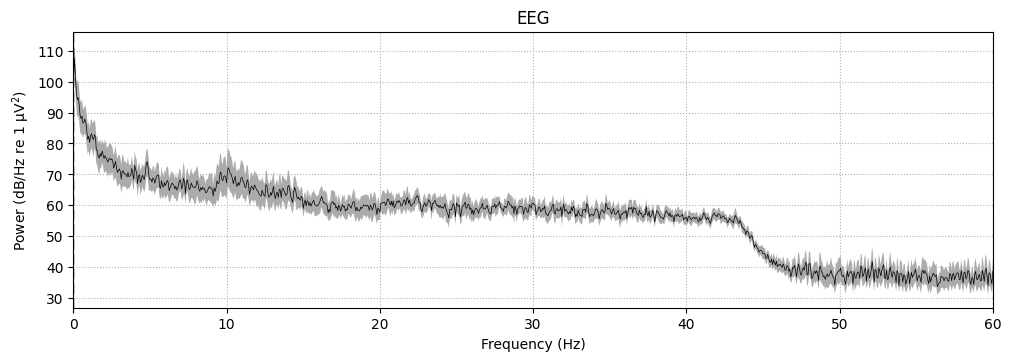

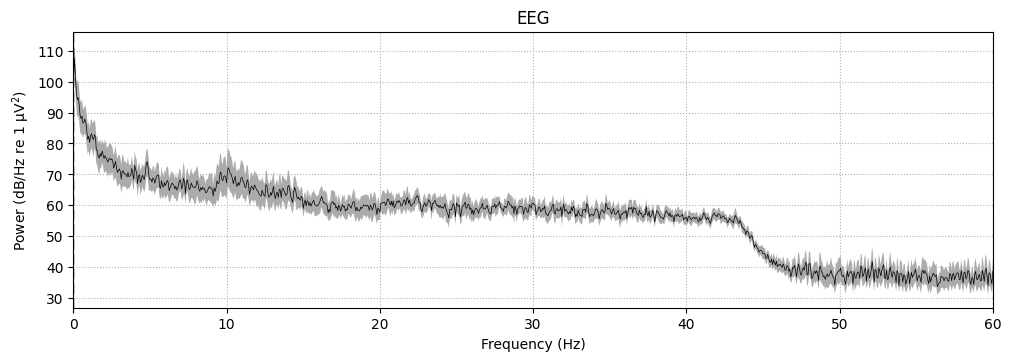

In [49]:
# 4️⃣  Plot power spectral density (frequency content)
# ---------------------------------------------------------
raw.plot_psd(fmax=60, average=True)

In [50]:
# 5️⃣  Quick data shape check
# ---------------------------------------------------------
data, times = raw.get_data(return_times=True)
print(f"\n📊 Data shape: {data.shape} (channels × time points)")
print(f"🕒 Total recording time: {times[-1]:.2f} seconds")

print("\n✅ Section 1.2 complete — EEG file successfully loaded and visualized.")


📊 Data shape: (32, 17664) (channels × time points)
🕒 Total recording time: 137.99 seconds

✅ Section 1.2 complete — EEG file successfully loaded and visualized.


## SECTION 2 - EEG PRE-PROCESSING

In [58]:
# =========================================================
# 🧩 SECTION 2 — ENHANCED EEG PREPROCESSING
# =========================================================

import mne, numpy as np, os

print(f"📂 Working on: {sample_file}")
raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)

# 1️⃣ Resample to common rate (optional)
raw.resample(128, npad="auto")
print("✅ Resampled to 128 Hz.")

# 2️⃣ Band-pass and Notch
raw.filter(1., 45., fir_design='firwin', verbose=False)
raw.notch_filter(freqs=[50], verbose=False)
print("✅ Filters applied.")

# 3️⃣ Re-reference
raw.set_eeg_reference('average', verbose=False)
print("✅ Re-referenced.")

# 4️⃣ Remove DC / baseline
raw.apply_function(lambda x: x - np.mean(x, axis=1, keepdims=True))
print("✅ Baseline drift removed.")

# 5️⃣ Automatic bad-channel detection (simple amplitude threshold)
bad_channels = [ch for ch in raw.ch_names if np.std(raw.get_data(picks=ch)) > 5e2]  # adjust threshold
raw.info['bads'] = bad_channels
if bad_channels:
    print("⚠️ Marked bad channels:", bad_channels)
    raw.interpolate_bads()
print("✅ Interpolated bad channels.")

# 6️⃣ ICA artifact removal (optional, slow)
# from mne.preprocessing import ICA
# ica = ICA(n_components=15, random_state=97)
# ica.fit(raw)
# ica.detect_artifacts(raw)
# raw = ica.apply(raw)
# print("✅ ICA artifact removal applied.")

# 7️⃣ Normalize (z-score)
data = raw.get_data()
data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)
raw._data = data
print("✅ Normalized channels.")

# Save
output_file = os.path.join(PREPROC_DIR, os.path.basename(sample_file).replace(".edf", "_enh_preproc.fif"))
raw.save(output_file, overwrite=True, verbose=False)
print(f"💾 Saved enhanced preprocessed EEG → {output_file}")

📂 Working on: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf
Sampling frequency of the instance is already 128.0, returning unmodified.
✅ Resampled to 128 Hz.
✅ Filters applied.
✅ Re-referenced.


AxisError: axis 1 is out of bounds for array of dimension 1